<a href="https://colab.research.google.com/github/geoaigroup/urbanai-map/blob/SAM/LangSAM_Webinar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### https://github.com/luca-medeiros/lang-segment-anything
Language Segment-Anything is an open-source project that combines the power of instance segmentation and text prompts to generate masks for specific objects in images. Built on the recently released Meta model, segment-anything, and the GroundingDINO detection model, it's an easy-to-use and effective tool for object detection and image segmentation.

In [1]:
import cv2
import numpy as np
import torch
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

MIN_AREA = 100


def load_image(image_path: str):
    return Image.open(image_path).convert("RGB")


def draw_image(image, masks, boxes, labels, alpha=0.4):
    image = torch.from_numpy(image).permute(2, 0, 1)
    image = draw_bounding_boxes(image, boxes, colors=['red'] * len(boxes), labels=labels, width=2)
    image = draw_segmentation_masks(image, masks=masks, colors=['cyan'] * len(boxes), alpha=alpha)
    return image.numpy().transpose(1, 2, 0)


def get_contours(mask):
    if len(mask.shape) > 2:
        mask = np.squeeze(mask, 0) #make it a 3d array 
    mask = mask.astype(np.uint8) # [0,1] range
    mask *= 255 # [0,255] range
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # findContours take 3 arguments : 
    #binary mask , contour retrieval mode(external contours),contour approximation method
    #it returns two outputs , hierarchy and contours. hierachy is set as dummy variable "_"
     
    effContours = []
    for c in contours:
        area = cv2.contourArea(c)
        if area > MIN_AREA:
            effContours.append(c)
    return effContours


def contour_to_points(contour):
    pointsNum = len(contour)
    contour = contour.reshape(pointsNum, -1).astype(np.float32)
    points = [point.tolist() for point in contour]
    return points


def generate_labelme_json(binary_masks, labels, image_size, image_path=None):
    """Generate a LabelMe format JSON file from binary mask tensor.
    Args:
        binary_masks: Binary mask tensor of shape [N, H, W].
        labels: List of labels for each mask.
        image_size: Tuple of (height, width) for the image size.
        image_path: Path to the image file (optional).
    Returns:
        A dictionary representing the LabelMe JSON file.
    """
    num_masks = binary_masks.shape[0]
    binary_masks = binary_masks.numpy()

    json_dict = {
        "version": "4.5.6",
        "imageHeight": image_size[0],
        "imageWidth": image_size[1],
        "imagePath": image_path,
        "flags": {},
        "shapes": [],
        "imageData": None
    }

    # Loop through the masks and add them to the JSON dictionary
    for i in range(num_masks):
        mask = binary_masks[i]
        label = labels[i]
        effContours = get_contours(mask)

        for effContour in effContours:
            points = contour_to_points(effContour)
            shape_dict = {
                "label": label,
                "line_color": None,
                "fill_color": None,
                "points": points,
                "shape_type": "polygon"
            }

            json_dict["shapes"].append(shape_dict)

    return json_dict

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install git+https://github.com/openai/CLIP.git

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 328 (delta 51), reused 56 (delta 38), pack-reused 228
Receiving objects: 100% (328/328), 12.35 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (156/156), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [5]:
import os
from urllib import request

import groundingdino.datasets.transforms as T
import numpy as np
import torch
import torch.nn as nn
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from huggingface_hub import hf_hub_download
from segment_anything import sam_model_registry
from segment_anything import SamPredictor

SAM_MODELS = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
}


def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print(f"Model loaded from {cache_file} \n => {log}")
    model.eval()
    return model


def transform_image(image) -> torch.Tensor:
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    image_transformed, _ = transform(image, None)
    return image_transformed


class LangSAM():

    def __init__(self, sam_type="vit_h"):
        self.sam_type = sam_type
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.build_groundingdino()
        self.build_sam(sam_type)

    def build_sam(self, sam_type):
        url = SAM_MODELS[sam_type]
        sam_checkpoint = os.path.basename(url)
        if not os.path.exists(sam_checkpoint):
            request.urlretrieve(url, sam_checkpoint)
        sam = sam_model_registry[sam_type](checkpoint=sam_checkpoint)
        sam.to(device=self.device)
        self.sam = SamPredictor(sam)

    def build_groundingdino(self):
        ckpt_repo_id = "ShilongLiu/GroundingDINO"
        ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
        ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
        self.groundingdino = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

    def predict_dino(self, image_pil, text_prompt, box_threshold, text_threshold):
        image_trans = transform_image(image_pil)
        boxes, logits, phrases = predict(model=self.groundingdino,
                                         image=image_trans,
                                         caption=text_prompt,
                                         box_threshold=box_threshold,
                                         text_threshold=text_threshold)
        W, H = image_pil.size
        boxes = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

        return boxes, logits, phrases

    def predict_sam(self, image_pil, boxes):
        image_array = np.asarray(image_pil)
        self.sam.set_image(image_array)
        transformed_boxes = self.sam.transform.apply_boxes_torch(boxes, image_array.shape[:2])
        masks, _, _ = self.sam.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes.to(self.sam.device),
            multimask_output=False,
        )
        return masks.cpu()

    def predict(self, image_pil, text_prompt, box_threshold=0.33, text_threshold=0.25):
        boxes, logits, phrases = self.predict_dino(image_pil, text_prompt, box_threshold, text_threshold)
        masks = torch.tensor([])
        if len(boxes) > 0:
            masks = self.predict_sam(image_pil, boxes)
            masks = masks.squeeze(1)
        return masks, boxes, phrases, logits



1.   Image + text --> grounding dino.
2. We extract the words whose similarities are higher than the text_threshold as predicted labels.
3. defaultly choose the boxes whose highest similarities are higher than box_threshold.
4. These boxes are fed to the Segment Anything Model. 




final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


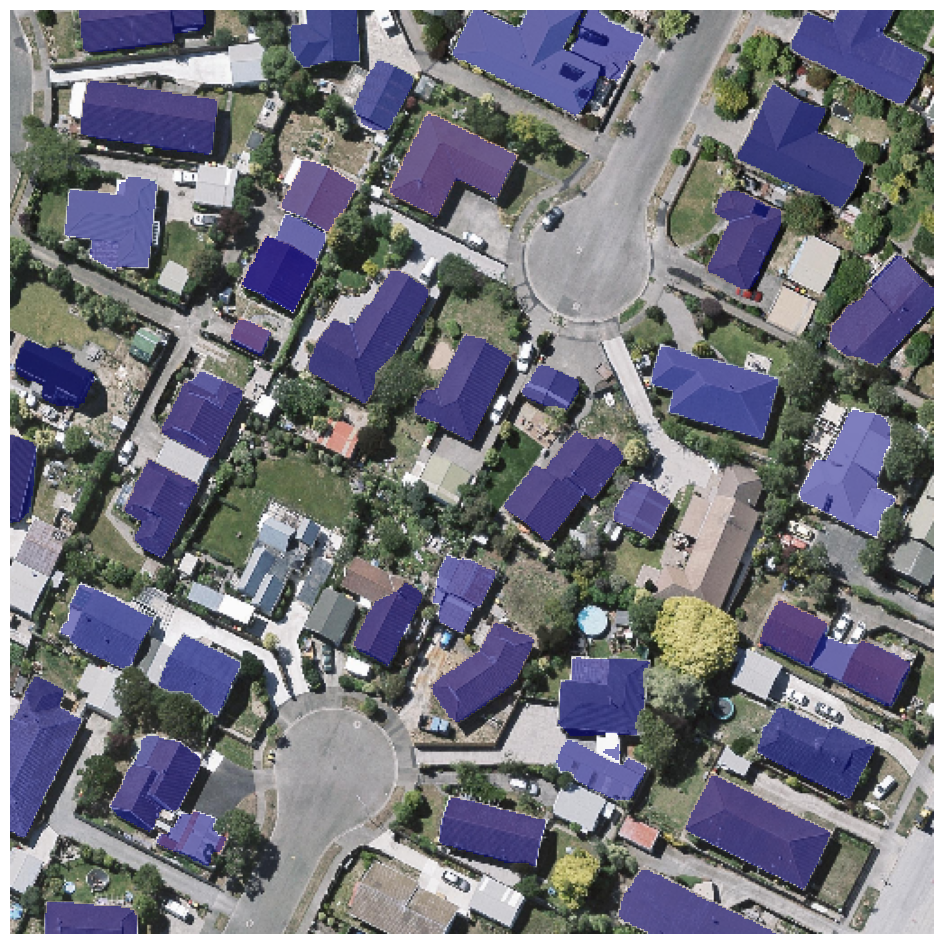

In [9]:
import numpy as np
import matplotlib.pyplot as plt

image = '/content/2_32.png'
model = LangSAM()
image_pil = Image.open(image).convert("RGB")
text_prompt = "house"
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

import numpy as np
import matplotlib.pyplot as plt

def display_image_with_masks(image, masks):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.axis('off')
    ax.imshow(image)
    
    num_masks = masks.shape[0]
    for i in range(num_masks):
        mask = masks[i].numpy()
        mask = np.ma.masked_where(mask < 0.5, mask)
        ax.imshow(mask, alpha=0.5, cmap='jet')
    
    # Display the figure in the notebook
    plt.show()

display_image_with_masks(image_pil , masks) 